In [23]:
import inspect
from torchvision.models.segmentation.segmentation import deeplabv3_mobilenet_v3_large

model = deeplabv3_mobilenet_v3_large(pretrained=True).to('cuda')
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

[(818047, 0), (103553, 15)]


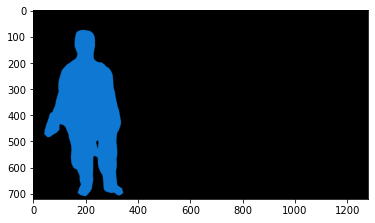

In [31]:
import cv2
import time
from PIL import Image
from torchvision import transforms
import numpy as np
import torch

path = "data/img_5_1/img_5_1_"
ball_class = 32
person_class = 0
file_name = "rectangles_yolo_img_5_1.mp4"
codec = cv2.VideoWriter_fourcc(*'mp4v')
outputStream = cv2.VideoWriter(file_name, codec, 25.0, (1280, 720), 0)
t = time.time()
for i in range(350, 500):
    img_path = path + str(i).zfill(4) + '.jpg'
    cv_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.expand(3,-1,-1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    t_img = preprocess(Image.fromarray(cv_img)).to('cuda')

    with torch.no_grad():
        res = model(t_img.unsqueeze(0))['out'][0]
    res = res.argmax(0)

    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(res.byte().cpu().numpy()).resize((1280, 720)).convert('P')
    print(colors[15])
    r.putpalette(colors)
    t_col = torch.zeros((720, 1280, 3))
    t_col[:, :, 0] = torch.from_numpy(np.array(r))

    import matplotlib.pyplot as plt
    plt.imshow(r)
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    for *xyxy, conf, cls in res:
        label = '%s %.2f' % (model.names[int(cls)], conf)
        # Draw box on image
        cv2.rectangle(img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
    cv2.imshow("Detecting Motion...", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    outputStream.write(img)
    print("Time to process frame "+str(i)+": ", time.time() - t)
    t = time.time()
    """
    break
cv2.destroyAllWindows()
outputStream.release()